In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://stages.ai/competitions/208/overview/description

# LGU+ 경진대회 - 베이스라인  
- [Neural Collaborative Filtering(NCF)](https://arxiv.org/pdf/1708.05031.pdf) 논문의 NeuMF를 참고하여 side-information을 결합한 모델을 PyTorch로 구현
- 구현된 모델의 검증 데이터셋과 리더보드의 성능을 확인

## 목차 
- 데이터 전처리 
    - 기본 설정
    - 데이터 불러오기 
    - 학습 및 검증 데이터 생성 
- NeuMF 구현    
    - 모델 구현 
    - 학습 및 추론 코드 구현
- 모델 학습 
    - 하이퍼파라미터 설정 & 최적화 기법 설정
    - 모델 학습 
    - 학습 과정 시각화 
- 제출 
    - 모든 유저에 대해 추천 결과 생성
    - 저장 

## 데이터 전처리
### 기본 설정

In [2]:
# 패키지 로드
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os, random

from scipy import sparse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import plotnine
from plotnine import *

In [3]:
# 하이퍼파라미터 
class cfg: 
    gpu_idx = 0
    device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")
    top_k = 25
    seed = 42
    neg_ratio = 100
    test_size = 0.2

In [4]:
# 시드 고정 
def seed_everything(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
seed_everything(cfg.seed)

In [5]:
# 경로 설정
data_path = '/content/drive/MyDrive/competition/2022 유플러스 AI Ground/data'
saved_path = '/content/drive/MyDrive/competition/2022 유플러스 AI Ground/code/saved'
output_path = '/content/drive/MyDrive/competition/2022 유플러스 AI Ground/code/submission'

### 데이터 불러오기
- history_data : 시청 시작 데이터
- profile_data : 프로필 정보 
- meta_data : 콘텐츠 일반 메타 정보

In [6]:
# 데이터 불러오기 
history_df = pd.read_csv(os.path.join(data_path, 'history_data.csv'), encoding='utf-8')
profile_df = pd.read_csv(os.path.join(data_path, 'profile_data.csv'), encoding='utf-8')
meta_df = pd.read_csv(os.path.join(data_path, 'meta_data.csv'), encoding='utf-8')

In [7]:
history_df

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
0,3,20220301115653,20220301115719,MKID003,15,NaN,Y,N
1,3,20220301115653,20220301115809,MKID003,16,NaN,Y,N
2,3,20220301115653,20220301115958,MKID003,17,NaN,Y,N
3,3,20220301115653,20220301120118,MKID003,18,NaN,Y,N
4,3,20220301115653,20220301120229,MKID003,19,NaN,Y,N
...,...,...,...,...,...,...,...,...
1005646,33032,20220427155091,20220427155668,MKID003,381,NaN,Y,N
1005647,33032,20220427155091,20220427155680,MKID003,381,NaN,Y,N
1005648,33032,20220427155839,20220427155810,MKID003,125,NaN,Y,N
1005649,33032,20220427155706,20220427155838,MKID003,125,NaN,Y,N


In [8]:
history_df['profile_id'].unique()

array([    3,     5,     7, ..., 33026, 33027, 33032])

In [9]:
# 이력이 제일 많은 유저 확인
dict_watch = {}
for id in history_df['profile_id'].unique():
  dict_watch[id] = len(history_df[history_df['profile_id'] == id])

In [10]:
max_id = max(dict_watch, key = dict_watch.get)

In [11]:
history_df[history_df['profile_id'] == max_id].sort_values(by = ['log_time'])

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
109724,2794,20220301000888,20220301000805,MKID003,2641,NaN,N,N
109725,2794,20220301000888,20220301001071,MKID003,3502,NaN,Y,N
109726,2794,20220301000888,20220301001071,MKID003,3502,NaN,Y,N
109727,2794,20220301000888,20220301001071,MKID003,3502,NaN,Y,N
109728,2794,20220301000888,20220301001071,MKID003,3502,NaN,Y,N
...,...,...,...,...,...,...,...,...
127909,2794,20220427173226,20220427180233,MKID003,1,NaN,Y,N
127910,2794,20220427173226,20220427180356,MKID003,14,NaN,Y,N
127911,2794,20220427173226,20220427180356,MKID003,14,NaN,Y,N
127912,2794,20220427173226,20220427180445,MKID003,2,NaN,Y,N


In [12]:
history_df[history_df['profile_id'] == 3].sort_values(by = ['log_time'])

,profile_id,ss_id,log_time,act_target_dtl,album_id,payment,continuous_play,short_trailer
0,3,20220301115653,20220301115719,MKID003,15,NaN,Y,N
1,3,20220301115653,20220301115809,MKID003,16,NaN,Y,N
2,3,20220301115653,20220301115958,MKID003,17,NaN,Y,N
3,3,20220301115653,20220301120118,MKID003,18,NaN,Y,N
4,3,20220301115653,20220301120229,MKID003,19,NaN,Y,N
5,3,20220301115653,20220301120450,MKID003,20,NaN,Y,N
6,3,20220301115653,20220301120654,MKID003,21,NaN,Y,N
7,3,20220301115653,20220301120859,MKID003,22,NaN,Y,N
8,3,20220301115653,20220301121104,MKID003,23,NaN,Y,N
9,3,20220301115653,20220301121308,MKID003,24,NaN,Y,N


In [13]:
# 약 7%의 자료가 유료구입
history_df['payment'].count()

73486

In [14]:
history_df['payment'].value_counts()  

500.0      46037
5040.0      8588
300.0       6782
5900.0      3976
700.0       1599
2500.0      1508
20000.0     1253
14000.0      919
9900.0       785
1200.0       560
8900.0       411
7500.0       353
1400.0       133
15000.0      127
3900.0       103
25000.0       76
11000.0       76
1680.0        63
4900.0        46
1500.0        27
19000.0       23
3500.0         6
5500.0         5
1000.0         4
5000.0         4
4200.0         3
2100.0         3
6300.0         2
12000.0        2
7770.0         2
8400.0         1
1260.0         1
2800.0         1
1890.0         1
6500.0         1
2940.0         1
7000.0         1
21420.0        1
3570.0         1
8750.0         1
Name: payment, dtype: int64

In [15]:
profile_df

,profile_id,sex,age,pr_interest_keyword_cd_1,pr_interest_keyword_cd_2,pr_interest_keyword_cd_3,ch_interest_keyword_cd_1,ch_interest_keyword_cd_2,ch_interest_keyword_cd_3
0,3,F,5,P02,P04,P07,K01,K03,K04
1,5,M,5,P07,P08,P06,K05,K08,K09
2,7,F,9,P05,P03,NaN,K06,K04,NaN
3,12,M,6,P03,P06,P02,K09,K07,K03
4,16,F,12,P03,P06,P01,K01,K06,K04
...,...,...,...,...,...,...,...,...,...
8306,33022,M,1,P04,NaN,NaN,K04,K08,NaN
8307,33023,M,5,P06,P03,P07,K08,K04,K05
8308,33026,F,8,P01,P03,P08,K05,K09,K06
8309,33027,F,4,P04,P05,P06,K03,K01,K05


In [16]:
meta_df

,album_id,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7
0,749,어둠이 무서워요,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
1,750,우리는 친구,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
2,2131,타요의 첫 운행,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
3,2625,길 잃은 타요,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
4,2594,새내기 꼬마 버스의 하루,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42597,39873,로티프렌즈와 색칠놀이! - 그리피 ＆ 사탕 바구니,로티프렌즈 미술놀이,키즈,놀이교실,NaN,한국,477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42598,39874,로티프렌즈와 색칠놀이! - 베블리 ＆ 꽃,로티프렌즈 미술놀이,키즈,놀이교실,NaN,한국,466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42599,4779,손가락을 빨게 돼요,4-5세,키즈,책,NaN,한국,293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42600,4779,손가락을 빨게 돼요,아이맘콕,키즈,책,NaN,한국,293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 학습 및 검증 데이터 생성 
- train : 시청 이력의 80%를 사용 
- valid : 시청 이력의 20%를 사용 

In [17]:
# 데이터 전처리 (중복제거) 
# 참고 : drop_duplicates의 subset을 무엇으로 구성하냐에 따라서 제거되는 항목들이 다름 
# ex) 'profile_id', 'album_id' : 중복된 시청이력 모두 제거 / 'profile_id', 'album_id', 'log_time' : 같은 시간에 시청한 이력만 제거 
data = history_df[['profile_id', 'log_time', 'album_id']].drop_duplicates(subset=['profile_id', 'album_id', 'log_time']).sort_values(by = ['profile_id', 'log_time']).reset_index(drop = True)
data['rating'] = 1

cfg.n_users = data.profile_id.max()+1
cfg.n_items = data.album_id.max()+1

In [18]:
# 학습 및 검증 데이터 분리
train, valid = train_test_split(
    data, test_size=cfg.test_size, random_state=cfg.seed,
)
print('학습 데이터 크기:', train.shape)
print('검증 데이터 크기:', valid.shape)

학습 데이터 크기: (719401, 4)
검증 데이터 크기: (179851, 4)


In [19]:
train

,profile_id,log_time,album_id,rating
80305,2367,20220422085064,3508,1
566567,16852,20220323091402,1992,1
553068,16213,20220424020218,2032,1
53822,1812,20220318171044,18,1
52051,1729,20220416214042,6340,1
...,...,...,...,...
259178,6646,20220404133329,471,1
365838,10024,20220402183652,9162,1
131932,3460,20220422202806,4924,1
671155,20590,20220402194102,831,1


In [20]:
import time
# Matrix 형태로 변환 
train = train.to_numpy()
matrix = sparse.lil_matrix((cfg.n_users, cfg.n_items))
for (p, _, i,  r) in tqdm(train):
  matrix[p, i] = r
    
train = sparse.csr_matrix(matrix)
train = train.toarray()
print("train 형태: \n", train)

  0%|          | 0/719401 [00:00<?, ?it/s]

train 형태: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [21]:
# 유저 특징 정보 추출 - 성별
profile_df = profile_df.set_index('profile_id')
user_features_sex = profile_df[['sex']].to_dict()
print("user_id 3의 sex 정보 :", user_features_sex['sex'][3])

user_id 3의 sex 정보 : F


In [22]:
# 유저 특징 정보 추출 - 부모관심키워드1
le = LabelEncoder()
profile_df['pr_interest_keyword_cd_1'] = le.fit_transform(profile_df['pr_interest_keyword_cd_1'])
user_features_pkey = profile_df[['pr_interest_keyword_cd_1']].to_dict()
print("user_id 3의 pkey 정보 :", user_features_pkey['pr_interest_keyword_cd_1'][3])

user_id 3의 pkey 정보 : 1


In [23]:
# 유저 특징 정보 추출 - 부모관심키워드2
le = LabelEncoder()
profile_df['pr_interest_keyword_cd_2'] = le.fit_transform(profile_df['pr_interest_keyword_cd_2'])
user_features_pkey2 = profile_df[['pr_interest_keyword_cd_2']].to_dict()
print("user_id 3의 pkey 정보 :", user_features_pkey2['pr_interest_keyword_cd_2'][3])

user_id 3의 pkey 정보 : 3


In [24]:
# 유저 특징 정보 추출 - 부모관심키워드3
le = LabelEncoder()
profile_df['pr_interest_keyword_cd_3'] = le.fit_transform(profile_df['pr_interest_keyword_cd_3'])
user_features_pkey3= profile_df[['pr_interest_keyword_cd_3']].to_dict()
print("user_id 3의 pkey 정보 :", user_features_pkey3['pr_interest_keyword_cd_3'][3])

user_id 3의 pkey 정보 : 6


In [25]:
# 유저 특징 정보 추출 - 아이관심키워드1
le = LabelEncoder()
profile_df['ch_interest_keyword_cd_1'] = le.fit_transform(profile_df['ch_interest_keyword_cd_1'])
user_features_chkey = profile_df[['ch_interest_keyword_cd_1']].to_dict()
print("user_id 3의 pkey 정보 :", user_features_chkey['ch_interest_keyword_cd_1'][3])

user_id 3의 pkey 정보 : 0


In [26]:
# 유저 특징 정보 추출 - 아이관심키워드2
le = LabelEncoder()
profile_df['ch_interest_keyword_cd_2'] = le.fit_transform(profile_df['ch_interest_keyword_cd_2'])
user_features_chkey2 = profile_df[['ch_interest_keyword_cd_2']].to_dict()
print("user_id 3의 pkey 정보 :", user_features_chkey2['ch_interest_keyword_cd_2'][3])

user_id 3의 pkey 정보 : 2


In [27]:
# 유저 특징 정보 추출 - 아이관심키워드3
le = LabelEncoder()
profile_df['ch_interest_keyword_cd_3'] = le.fit_transform(profile_df['ch_interest_keyword_cd_3'])
user_features_chkey3 = profile_df[['ch_interest_keyword_cd_3']].to_dict()
print("user_id 3의 pkey 정보 :", user_features_chkey3['ch_interest_keyword_cd_3'][3])

user_id 3의 pkey 정보 : 3


In [28]:
# 유저 특징 정보 추출 
user_features = profile_df[['age']].to_dict()
print("user_id 3의 age 정보 :", user_features['age'][3])

user_id 3의 age 정보 : 5


In [29]:
# 아이템 특징 정보 추출 
meta_df = meta_df.set_index('album_id')

# 범주형 데이터를 수치형 데이터로 변경 
le = LabelEncoder()
meta_df['genre_mid'] = le.fit_transform(meta_df['genre_mid'])
item_features = meta_df[['genre_mid']].to_dict()
print("album_id 749의 genre_mid 정보 :", item_features['genre_mid'][749])

album_id 749의 genre_mid 정보 : 1


In [30]:
profile_df[['pr_interest_keyword_cd_1']].nunique()

pr_interest_keyword_cd_1    8
dtype: int64

In [31]:
# 추출한 특징 정보의 속성을 저장 
cfg.n_genres = meta_df['genre_mid'].nunique()
cfg.n_continuous_feats = 1 
cfg.n_pkey = profile_df[['pr_interest_keyword_cd_1']].nunique()

In [32]:
# 추출한 특징 정보의 속성을 저장 
cfg.n_chkey = profile_df[['ch_interest_keyword_cd_1']].nunique()

In [33]:
profile_df[['ch_interest_keyword_cd_3']].nunique()

ch_interest_keyword_cd_3    10
dtype: int64

In [34]:
profile_df[['pr_interest_keyword_cd_3']].nunique()

pr_interest_keyword_cd_3    9
dtype: int64

In [35]:
cfg.n_chkey

ch_interest_keyword_cd_1    9
dtype: int64

## NeuMF 구현


### 모델 구현 
- [Neural Collaborative Filtering(NCF)](https://arxiv.org/pdf/1708.05031.pdf) 논문의 NeuMF를 참고하여 side-information을 결합한 모델을 PyTorch로 구현
    - continuous feature (age)와 categorical feature (genre_mid)를 같이 학습할 수 있도록 결합

![](http://drive.google.com/uc?export=view&id=1tpajTLipLoFdvLICO-alAxeoKAE8-k61)

In [36]:
class NeuMF(nn.Module):
    """Neural Matrix Factorization Model
        참고 문헌 : https://arxiv.org/abs/1708.05031

    예시 :
        model = NeuMF(cfg) 
        output = model.forward(user_ids, item_ids, [feat0, feat1]) 
    """
    def __init__(self, cfg):
        """ 
        Args:
            cfg : config 파일로 네트워크 생성에 필요한 정보들을 담고 있음 
        """
        super(NeuMF, self).__init__()
        self.n_users = cfg.n_users
        self.n_items = cfg.n_items
        self.emb_dim = cfg.emb_dim
        self.layer_dim = cfg.layer_dim
        self.n_continuous_feats = cfg.n_continuous_feats
        self.n_genres = cfg.n_genres
        self.dropout = cfg.dropout
        self.build_graph()

    def build_graph(self):
        """Neural Matrix Factorization Model 생성
            구현된 모습은 위의 그림을 참고 
        """
        self.user_embedding_mf = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)
        self.item_embedding_mf = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
        
        self.user_embedding_mlp = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)
        self.item_embedding_mlp = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
        self.userpkey_embedding_mlp = nn.Embedding(num_embeddings=8, embedding_dim=self.emb_dim)   
        self.userpkey_embedding_mlp2 = nn.Embedding(num_embeddings=9, embedding_dim=self.emb_dim)   
        # self.userpkey_embedding_mlp2 = nn.Embedding(num_embeddings=8, embedding_dim=self.emb_dim)
        # self.userpkey_embedding_mlp3 = nn.Embedding(num_embeddings=8, embedding_dim=self.emb_dim)
        self.userchkey_embedding_mlp = nn.Embedding(num_embeddings=9, embedding_dim=self.emb_dim)
        self.userchkey_embedding_mlp2 = nn.Embedding(num_embeddings=10, embedding_dim=self.emb_dim)
        # self.userchkey_embedding_mlp2 = nn.Embedding(num_embeddings=9, embedding_dim=self.emb_dim)
        # self.userchkey_embedding_mlp3 = nn.Embedding(num_embeddings=9, embedding_dim=self.emb_dim)

        self.usersex_embedding_mlp = nn.Embedding(num_embeddings=2, embedding_dim=self.emb_dim)        

        self.genre_embeddig = nn.Embedding(num_embeddings=self.n_genres, embedding_dim=self.n_genres//2)
        
        self.mlp_layers = nn.Sequential(
            nn.Linear(9*self.emb_dim + self.n_genres//2 + self.n_continuous_feats, self.layer_dim), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout), 
            nn.Linear(self.layer_dim, self.layer_dim//2), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout)
        )
        self.affine_output = nn.Linear(self.layer_dim//2 + self.emb_dim, 1)
        self.apply(self._init_weights)
        

    def _init_weights(self, module):
        if isinstance(module, nn.Embedding):
            normal_(module.weight.data, mean=0.0, std=0.01)
        elif isinstance(module, nn.Linear):
            normal_(module.weight.data, 0, 0.01)
            if module.bias is not None:
                module.bias.data.fill_(0.0)
    
    def forward(self, user_indices, item_indices, feats):
        """ 
        Args:
            user_indices : 유저의 인덱스 정보 
                ex) tensor([ 3100,  3100,  ..., 14195, 14195])
            item_indices : 아이템의 인덱스 정보
                ex) tensor([   50,    65,   ..., 14960, 11527])
            feats : 특징 정보 
        Returns: 
            output : 유저-아이템 쌍에 대한 추천 결과 
                ex) tensor([  9.4966,  22.0261, ..., -19.3535, -23.0212])
        """
        user_embedding_mf = self.user_embedding_mf(user_indices)
        item_embedding_mf = self.item_embedding_mf(item_indices)
        mf_output = torch.mul(user_embedding_mf, item_embedding_mf)
        
        user_embedding_mlp = self.user_embedding_mlp(user_indices)
        item_embedding_mlp = self.item_embedding_mlp(item_indices)
        usersex_embedding_mlp = self.usersex_embedding_mlp(feats[0])
        userpkey_embedding_mlp = self.userpkey_embedding_mlp(feats[3])
        userpkey_embedding_mlp2 = self.userpkey_embedding_mlp2(feats[4])
        userpkey_embedding_mlp3 = self.userpkey_embedding_mlp2(feats[5])
        userchkey_embedding_mlp = self.userchkey_embedding_mlp(feats[6])
        userchkey_embedding_mlp2 = self.userchkey_embedding_mlp2(feats[7])
        userchkey_embedding_mlp3 = self.userchkey_embedding_mlp2(feats[8])
        genre_embedding_mlp = self.genre_embeddig(feats[2])

        input_feature = torch.cat((user_embedding_mlp, item_embedding_mlp, usersex_embedding_mlp, genre_embedding_mlp, userpkey_embedding_mlp,userpkey_embedding_mlp2, userpkey_embedding_mlp3, userchkey_embedding_mlp,userchkey_embedding_mlp2,userchkey_embedding_mlp3, feats[1].unsqueeze(1)), -1)
        mlp_output = self.mlp_layers(input_feature)
        
        output = torch.cat([mlp_output, mf_output], dim=-1)
        output = self.affine_output(output).squeeze(-1)
        return output

### 학습 및 추론 코드 구현

- 학습 : Negative sampling을 활용하여 Binary Classification 진행 
    - history 에 있는 album_id는 positive label로 그렇지 않은 album_id는 nagative label로 활용  
    - 단, 이때 모든 album_id를 negative label로 활용하는 것이 아닌 일부만 사용 (neg_ratio 값에 따라서 개수 조정)
- 추론 : 일부 데이터에 대해 recall, ndcg, coverage 성능 확인

#### 학습 및 추론에 필요한 데이터 셋 생성 코드 구현

In [37]:
import time
def make_UIdataset(train, neg_ratio):
    """ 유저별 학습에 필요한 딕셔너리 데이터 생성 
    Args:
        train : 유저-아이템의 상호작용을 담은 행렬 
            ex) 
                array([[0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        ...,
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.]])
        neg_ratio : negative sampling 활용할 비율 
            ex) 3 (positive label 1개당 negative label 3개)
    Returns: 
        UIdataset : 유저별 학습에 필요한 정보를 담은 딕셔너리 
            ex) {'사용자 ID': [[positive 샘플, negative 샘플], ... , [1, 1, 1, ..., 0, 0]]}
                >>> UIdataset[3]
                    [array([   16,    17,    18, ...,  9586, 18991,  9442]),
                    array([5, 5, 5, ..., 5, 5, 5]),
                    array([4, 4, 4, ..., 5, 1, 1]),
                    array([1., 1., 1., ..., 0., 0., 0.])]
    """
    UIdataset = {}
    for user_id, items_by_user in enumerate(train):
        UIdataset[user_id] = []
        # positive 샘플 계산 
        pos_item_ids = np.where(items_by_user > 0.5)[0]
        num_pos_samples = len(pos_item_ids)

        # negative 샘플 계산 (random negative sampling) 
        num_neg_samples = neg_ratio * num_pos_samples
        neg_items = np.where(items_by_user < 0.5)[0]
        neg_item_ids = np.random.choice(neg_items, min(num_neg_samples, len(neg_items)), replace=False)
        UIdataset[user_id].append(np.concatenate([pos_item_ids, neg_item_ids]))
        
        # feature 추출 - sex
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(user_features_sex['sex'][user_id])
        if features != []:
          UIdataset[user_id].append(np.where(np.array(features) == 'F', 0, 1))
        else:
          UIdataset[user_id].append(np.array(features))

        # age
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(user_features['age'][user_id])
        UIdataset[user_id].append(np.array(features))
        
        # 장르
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(item_features['genre_mid'][item_id])
        UIdataset[user_id].append(np.array(features))

        # pkey
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(user_features_pkey['pr_interest_keyword_cd_1'][user_id])
        UIdataset[user_id].append(np.array(features))
        
        # pkey2
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(user_features_pkey2['pr_interest_keyword_cd_2'][user_id])
        UIdataset[user_id].append(np.array(features))

        # pkey3
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(user_features_pkey3['pr_interest_keyword_cd_3'][user_id])
        UIdataset[user_id].append(np.array(features))

        # chkey
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(user_features_chkey['ch_interest_keyword_cd_1'][user_id])
        UIdataset[user_id].append(np.array(features))

        # chkey2
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(user_features_chkey2['ch_interest_keyword_cd_2'][user_id])
        UIdataset[user_id].append(np.array(features))

        # chkey3
        features = []
        for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
            features.append(user_features_chkey3['ch_interest_keyword_cd_3'][user_id])
        UIdataset[user_id].append(np.array(features))

        # label 저장  
        pos_labels = np.ones(len(pos_item_ids))
        neg_labels = np.zeros(len(neg_item_ids))
        UIdataset[user_id].append(np.concatenate([pos_labels, neg_labels]))

    return UIdataset

In [38]:
UIdataset = make_UIdataset(train, neg_ratio=cfg.neg_ratio)

In [39]:
UIdataset[3]

[array([   16,    17,    18, ...,  9586, 18991,  9442]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([5, 5, 5, ..., 5, 5, 5]),
 array([4, 4, 4, ..., 5, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([3, 3, 3, ..., 3, 3, 3]),
 array([6, 6, 6, ..., 6, 6, 6]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([2, 2, 2, ..., 2, 2, 2]),
 array([3, 3, 3, ..., 3, 3, 3]),
 array([1., 1., 1., ..., 0., 0., 0.])]

In [40]:
UIdataset[3][1]

array([0, 0, 0, ..., 0, 0, 0])

In [41]:
def make_batchdata(user_indices, batch_idx, batch_size):
    """ 배치 데이터로 변환 
    Args:
        user_indices : 전체 유저의 인덱스 정보 
            ex) array([ 3100,  1800, 30098, ...,  2177, 11749, 20962])
        batch_idx : 배치 인덱스 (몇번째 배치인지)
            ex) 0 
        batch_size : 배치 크기 
            ex) 256 
    Returns 
        batch_user_ids : 배치내의 유저 인덱스 정보 
            ex) [22194, 22194, 22194, 22194, 22194, ...]
        batch_item_ids : 배치내의 아이템 인덱스 정보 
            ex) [36, 407, 612, 801, 1404, ...]
        batch_feat0 : 배치내의 유저-아이템 인덱스 정보에 해당하는 feature0 정보 
            ex) [6, 6, 6, 6, 6, ...]
        batch_feat1 : 배치내의 유저-아이템 인덱스 정보에 해당하는 feature1 정보 
            ex) [4,  4,  4, 23,  4, ...]
        batch_labels : 배치내의 유저-아이템 인덱스 정보에 해당하는 label 정보 
            ex) [1.0, 1.0, 1.0, 1.0, 1.0, ...]
    """
    batch_user_indices = user_indices[batch_idx*batch_size : (batch_idx+1)*batch_size]
    batch_user_ids = []
    batch_item_ids = []
    batch_feat0 = []
    batch_feat1 = []
    batch_feat2 = []
    batch_feat3 = []
    batch_feat4 = []
    batch_feat5 = []
    batch_feat6 = []
    batch_feat7 = []
    batch_feat8 = []
    batch_feat9 = []
    
    batch_labels = []
    for user_id in batch_user_indices:
        item_ids = UIdataset[user_id][0]
        feat0 = UIdataset[user_id][1] # sex
        feat1 = UIdataset[user_id][2] # age
        feat2 = UIdataset[user_id][3] # genre

        # pkey1,2,3
        feat3 = UIdataset[user_id][4]
        feat4 = UIdataset[user_id][5]
        feat5 = UIdataset[user_id][6]

        # chkey1,2,3
        feat6 = UIdataset[user_id][7]
        feat7 = UIdataset[user_id][8]
        feat8 = UIdataset[user_id][9]

        labels = UIdataset[user_id][10]
        user_ids = np.full(len(item_ids), user_id)

        batch_user_ids.extend(user_ids.tolist())
        batch_item_ids.extend(item_ids.tolist())
        batch_feat0.extend(feat0.tolist())
        batch_feat1.extend(feat1.tolist())
        batch_feat2.extend(feat2.tolist())
        batch_feat3.extend(feat3.tolist())
        batch_feat4.extend(feat4.tolist())
        batch_feat5.extend(feat5.tolist())
        batch_feat6.extend(feat6.tolist())
        batch_feat7.extend(feat7.tolist())
        batch_feat8.extend(feat8.tolist())
        
        batch_labels.extend(labels.tolist())
    return batch_user_ids, batch_item_ids, batch_feat0, batch_feat1,batch_feat2, batch_feat3, batch_feat4, batch_feat5, batch_feat6, batch_feat7, batch_feat8, batch_labels

def update_avg(curr_avg, val, idx):
    """ 현재 epoch 까지의 평균 값을 계산 
    """
    return (curr_avg * idx + val) / (idx + 1)

#### 학습 및 검증 코드 생성

In [42]:
def train_epoch(cfg, model, optimizer, criterion): 
    model.train()
    curr_loss_avg = 0.0

    user_indices = np.arange(cfg.n_users)
    np.random.RandomState(cfg.epoch).shuffle(user_indices)
    batch_num = int(len(user_indices) / cfg.batch_size) + 1
    bar = tqdm(range(batch_num), leave=False)
    for step, batch_idx in enumerate(bar):
        user_ids, item_ids, feat0, feat1, feat2, feat3, feat4, feat5, feat6, feat7, feat8, labels = make_batchdata(user_indices, batch_idx, cfg.batch_size)
        # 배치 사용자 단위로 학습
        user_ids = torch.LongTensor(user_ids).to(cfg.device)
        item_ids = torch.LongTensor(item_ids).to(cfg.device)
        feat0 = torch.LongTensor(feat0).to(cfg.device)
        feat1 = torch.LongTensor(feat1).to(cfg.device)
        feat2 = torch.LongTensor(feat2).to(cfg.device)
        feat3 = torch.LongTensor(feat3).to(cfg.device)
        feat4 = torch.LongTensor(feat4).to(cfg.device)
        feat5 = torch.LongTensor(feat5).to(cfg.device)
        feat6 = torch.LongTensor(feat6).to(cfg.device)
        feat7 = torch.LongTensor(feat7).to(cfg.device)
        feat8 = torch.LongTensor(feat8).to(cfg.device)

        labels = torch.FloatTensor(labels).to(cfg.device)
        labels = labels.view(-1, 1)

        # grad 초기화
        optimizer.zero_grad()

        # 모델 forward
        output = model.forward(user_ids, item_ids, [feat0, feat1, feat2, feat3, feat4, feat5, feat6, feat7, feat8])
        output = output.view(-1, 1)

        loss = criterion(output, labels)

        # 역전파
        loss.backward()

        # 최적화
        optimizer.step()    
        if torch.isnan(loss):
            print('Loss NAN. Train finish.')
            break
        curr_loss_avg = update_avg(curr_loss_avg, loss, step)
        
        msg = f"epoch: {cfg.epoch}, "
        msg += f"loss: {curr_loss_avg.item():.5f}, "
        msg += f"lr: {optimizer.param_groups[0]['lr']:.6f}"
        bar.set_description(msg)
    rets = {'losses': np.around(curr_loss_avg.item(), 5)}
    return rets

In [43]:
def recallk(actual, predicted, k = 25):
    """ label과 prediction 사이의 recall 평가 함수 
    Args:
        actual : 실제로 본 상품 리스트
        pred : 예측한 상품 리스트
        k : 상위 몇개의 데이터를 볼지 (ex : k=5 상위 5개의 상품만 봄)
    Returns: 
        recall_k : recall@k 
    """ 
    set_actual = set(actual)
    recall_k = len(set_actual & set(predicted[:k])) / min(k, len(set_actual))
    return recall_k

def unique(sequence):
    # preserves order
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

def ndcgk(actual, predicted, k = 25):
    set_actual = set(actual)
    idcg = sum([1.0 / np.log(i + 2) for i in range(min(k, len(set_actual)))])
    dcg = 0.0
    unique_predicted = unique(predicted[:k])
    for i, r in enumerate(unique_predicted):
        if r in set_actual:
            dcg += 1.0 / np.log(i + 2)
    ndcg_k = dcg / idcg
    return ndcg_k

def evaluation(gt, pred):
    """ label과 prediction 사이의 recall, coverage, competition metric 평가 함수 
    Args:
        gt : 데이터 프레임 형태의 정답 데이터 
        pred : 데이터 프레임 형태의 예측 데이터 
    Returns: 
        rets : recall, ndcg, coverage, competition metric 결과 
            ex) {'recall': 0.123024, 'ndcg': 056809, 'coverage': 0.017455, 'score': 0.106470}
    """    
    gt = gt.groupby('profile_id')['album_id'].unique().to_frame().reset_index()
    gt.columns = ['profile_id', 'actual_list']

    evaluated_data = pd.merge(pred, gt, how = 'left', on = 'profile_id')

    evaluated_data['Recall@25'] = evaluated_data.apply(lambda x: recallk(x.actual_list, x.predicted_list), axis=1)
    evaluated_data['NDCG@25'] = evaluated_data.apply(lambda x: ndcgk(x.actual_list, x.predicted_list), axis=1)

    recall = evaluated_data['Recall@25'].mean()
    ndcg = evaluated_data['NDCG@25'] .mean()
    coverage = (evaluated_data['predicted_list'].apply(lambda x: x[:cfg.top_k]).explode().nunique())/meta_df.index.nunique()

    score = 0.75*recall + 0.25*ndcg
    rets = {"recall" :recall, 
            "ndcg" :ndcg, 
            "coverage" :coverage, 
            "score" :score}
    return rets

In [44]:
def valid_epoch(cfg, model, data, mode='valid'):
    pred_list = []
    model.eval()
    
    query_user_ids = data['profile_id'].unique() # 추론할 모든 user array 집합
    full_item_ids = np.array([c for c in range(cfg.n_items)]) # 추론할 모든 item array 집합 
    full_item_ids_feat1 = [item_features['genre_mid'][c] for c in full_item_ids]
    for user_id in query_user_ids:
        with torch.no_grad():
            user_ids = np.full(cfg.n_items, user_id)
            
            user_ids = torch.LongTensor(user_ids).to(cfg.device)
            item_ids = torch.LongTensor(full_item_ids).to(cfg.device)

            feat0 = np.full(cfg.n_items, 0 if user_features_sex['sex'][3] =='F' else 1)
            feat0 = torch.LongTensor(feat0).to(cfg.device)
            feat1 = np.full(cfg.n_items, user_features['age'][user_id])
            feat1 = torch.LongTensor(feat1).to(cfg.device)
            feat2 = torch.LongTensor(full_item_ids_feat1).to(cfg.device)
            feat3 = np.full(cfg.n_items, user_features_pkey['pr_interest_keyword_cd_1'][user_id])
            feat3 = torch.LongTensor(feat3).to(cfg.device)
            feat4 = np.full(cfg.n_items, user_features_pkey2['pr_interest_keyword_cd_2'][user_id])
            feat4 = torch.LongTensor(feat4).to(cfg.device)
            feat5 = np.full(cfg.n_items, user_features_pkey3['pr_interest_keyword_cd_3'][user_id])
            feat5 = torch.LongTensor(feat5).to(cfg.device)

            feat6 = np.full(cfg.n_items, user_features_chkey['ch_interest_keyword_cd_1'][user_id])
            feat6 = torch.LongTensor(feat6).to(cfg.device)
            feat7 = np.full(cfg.n_items, user_features_chkey2['ch_interest_keyword_cd_2'][user_id])
            feat7 = torch.LongTensor(feat7).to(cfg.device)
            feat8 = np.full(cfg.n_items, user_features_chkey3['ch_interest_keyword_cd_3'][user_id])
            feat8 = torch.LongTensor(feat8).to(cfg.device)

            eval_output = model.forward(user_ids, item_ids, [feat0, feat1, feat2, feat3, feat4, feat5, feat6, feat7, feat8]).detach().cpu().numpy()
            pred_u_score = eval_output.reshape(-1)   
        
        pred_u_idx = np.argsort(pred_u_score)[::-1]
        pred_u = full_item_ids[pred_u_idx]
        pred_list.append(list(pred_u[:cfg.top_k]))
        
    pred = pd.DataFrame()
    pred['profile_id'] = query_user_ids
    pred['predicted_list'] = pred_list
    
    # 모델 성능 확인 
    if mode == 'valid':
        rets = evaluation(data, pred)
        return rets, pred
    return pred

## 모델 학습

### 하이퍼파라미터 설정 & 최적화 기법 설정

In [45]:
# 하이퍼 파라미터 설정 
cfg.batch_size = 256
cfg.emb_dim = 256
cfg.layer_dim = 256
cfg.dropout = 0.05
cfg.epochs = 25
cfg.learning_rate = 0.0025
cfg.reg_lambda = 0
cfg.check_epoch = 1

In [46]:
# model 생성 및 optimizer, loss 함수 설정 
model = NeuMF(cfg).to(cfg.device)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate, weight_decay=cfg.reg_lambda)
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

### 학습 진행

In [47]:
total_logs = defaultdict(list)
best_scores  = 0
for epoch in range(cfg.epochs+1):
    cfg.epoch = epoch
    train_results = train_epoch(cfg, model, optimizer, criterion)
    
    # cfg.check_epoch 번의 epoch 마다 성능 확인 
    if epoch % cfg.check_epoch == 0: 
        valid_results, _ = valid_epoch(cfg, model, valid)

        logs = {
            'Train Loss': train_results['losses'],
            f'Valid Recall@{cfg.top_k}': valid_results['recall'],
            f'Valid NDCG@{cfg.top_k}': valid_results['ndcg'],
            'Valid Coverage': valid_results['coverage'],
            'Valid Score': valid_results['score'],
            }

        # 검증 성능 확인 
        for key, value in logs.items():
            total_logs[key].append(value)

        if epoch == 0:
            print("Epoch", end=",")
            print(",".join(logs.keys()))

        print(f"{epoch:02d}  ", end="")
        print("  ".join([f"{v:0.6f}" for v in logs.values()]))
        
        # 가장 성능이 좋은 가중치 파일을 저장 
        if best_scores <= valid_results['score']: 
            best_scores = valid_results['score']
            torch.save(model.state_dict(), os.path.join(saved_path, 'model(add_sex_pkey_chkey_25epoch).pth'))

  0%|          | 0/130 [00:00<?, ?it/s]

Epoch,Train Loss,Valid Recall@25,Valid NDCG@25,Valid Coverage,Valid Score
00  21673.009770  0.155961  0.116606  0.000652  0.146122


  0%|          | 0/130 [00:00<?, ?it/s]

01  10011.022460  0.216504  0.172974  0.004439  0.205622


  0%|          | 0/130 [00:00<?, ?it/s]

02  8195.513670  0.370042  0.275994  0.056953  0.346530


  0%|          | 0/130 [00:00<?, ?it/s]

03  6023.297850  0.446838  0.331795  0.123034  0.418077


  0%|          | 0/130 [00:00<?, ?it/s]

04  4153.346190  0.484695  0.352447  0.208226  0.451633


  0%|          | 0/130 [00:00<?, ?it/s]

05  2707.573970  0.494566  0.358223  0.283411  0.460481


  0%|          | 0/130 [00:00<?, ?it/s]

06  1796.621460  0.499687  0.361376  0.319599  0.465109


  0%|          | 0/130 [00:00<?, ?it/s]

07  1217.546510  0.503046  0.361818  0.337103  0.467739


  0%|          | 0/130 [00:00<?, ?it/s]

08  827.881900  0.501071  0.361410  0.348589  0.466156


  0%|          | 0/130 [00:00<?, ?it/s]

09  579.814580  0.502251  0.361484  0.350370  0.467059


  0%|          | 0/130 [00:00<?, ?it/s]

10  407.775090  0.502172  0.361973  0.348940  0.467122


  0%|          | 0/130 [00:00<?, ?it/s]

11  289.801790  0.501811  0.360930  0.354157  0.466590


  0%|          | 0/130 [00:00<?, ?it/s]

12  202.639740  0.502172  0.360619  0.349041  0.466784


  0%|          | 0/130 [00:00<?, ?it/s]

13  142.236180  0.503495  0.361407  0.353154  0.467973


  0%|          | 0/130 [00:00<?, ?it/s]

14  104.369090  0.502435  0.360666  0.353404  0.466993


  0%|          | 0/130 [00:00<?, ?it/s]

15  80.330830  0.502578  0.360423  0.352502  0.467039


  0%|          | 0/130 [00:00<?, ?it/s]

16  64.185050  0.502221  0.360181  0.352476  0.466711


  0%|          | 0/130 [00:00<?, ?it/s]

17  52.375940  0.502170  0.360394  0.351975  0.466726


  0%|          | 0/130 [00:00<?, ?it/s]

18  43.529400  0.502477  0.360206  0.351624  0.466909


  0%|          | 0/130 [00:00<?, ?it/s]

19  36.498850  0.501914  0.360042  0.352125  0.466446


  0%|          | 0/130 [00:00<?, ?it/s]

20  31.040830  0.501879  0.360070  0.351348  0.466427


  0%|          | 0/130 [00:00<?, ?it/s]

21  26.561980  0.501927  0.360165  0.350320  0.466487


  0%|          | 0/130 [00:00<?, ?it/s]

22  22.939730  0.501890  0.359997  0.351122  0.466417


  0%|          | 0/130 [00:00<?, ?it/s]

23  19.905320  0.501874  0.360231  0.350470  0.466463


  0%|          | 0/130 [00:00<?, ?it/s]

24  17.382610  0.501295  0.359747  0.349893  0.465908


  0%|          | 0/130 [00:00<?, ?it/s]

25  15.225900  0.501486  0.359837  0.349066  0.466074


### 학습 과정 시각화

In [48]:
train_scores = pd.DataFrame({'Train loss': total_logs['Train Loss']})
train_scores['Epoch'] = range(0, cfg.epochs+1, cfg.check_epoch)

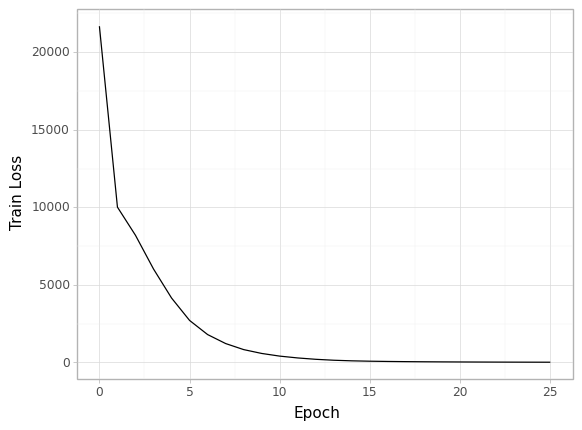

<ggplot: (8748113478025)>

In [49]:
(
    ggplot(train_scores, aes(x='Epoch', y='Train loss'))
        + geom_line(color='black') # line plot
        + labs(x='Epoch', y='Train Loss')
        + theme_light()
)

In [50]:
valid_scores = pd.DataFrame(np.hstack([(range(0, cfg.epochs+1, cfg.check_epoch), total_logs[score], [score for i in range(0, cfg.epochs+1, cfg.check_epoch)]) for score in ['Valid Recall@25', 'Valid NDCG@25', 'Valid Coverage', 'Valid Score']])).T
valid_scores.columns = ['Epoch', 'Score', 'Metric']
valid_scores['Epoch'] = valid_scores['Epoch'].astype(int)
valid_scores['Score'] = valid_scores['Score'].astype(float)

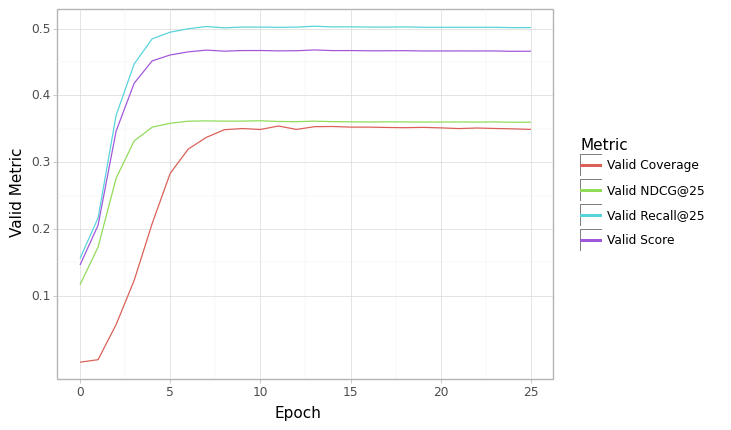

<ggplot: (8747173005309)>

In [51]:
(
ggplot(valid_scores)  # here
    + aes("Epoch", "Score", color='Metric', group='Metric')
    + geom_line()
    + scale_y_continuous(breaks=[0.1*c for c in range(1, 10, 1)])
    + theme_light()
    + labs(x='Epoch', y='Valid Metric')
)  

## 제출 
### 모든 유저에 대해 추천 결과 생성

In [52]:
model.load_state_dict(torch.load(os.path.join(saved_path, 'model(add_sex_pkey_chkey_25epoch).pth')))

<All keys matched successfully>

In [53]:
submission_path = os.path.join(data_path, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission = valid_epoch(cfg, model, submission, mode='test')

### 저장

In [54]:
submission.to_csv(os.path.join(output_path, 'submission_add_sex_pkey_chkey_25epoch.csv'), index = False)